In [2]:
import os
import shutil
import xml.etree.ElementTree as ET
import tarfile, zipfile
import pickle
import numpy as np
from PIL import Image
from src.data.preproc import text_standardize,preprocess
import gc
import cv2
import pandas as pd
from joblib import Parallel, delayed, cpu_count


In [3]:
def resize(img, size):
    wt, ht, _ = size
    h, w = np.asarray(img).shape
    f = max((w / wt), (h / ht))
    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))
    img = cv2.resize(img, new_size)

    target = np.ones([ht, wt], dtype=np.uint8) * 255
    target[0:new_size[1], 0:new_size[0]] = img
    return target

In [4]:
size = (512,512,3)

In [5]:
def format_IAM_paragraph():
    """
    Format the IAM dataset at paragraph level with the commonly used split (747 for train, 116 for validation and 336 for test)
    """
    source_folder = "raw/iam/paragrah_xmls/"
    target_folder = "formatted/IAM_paragraph"
    img_folder_path = "raw/iam/forms/"

    gt = {
        "train": dict(),
        "valid": dict(),
        "test": dict()
    }

    dataset = {}
    for set_name in ["train", "test", "valid"]:
        dataset[set_name] = {"dt": [], "gt": []}
        print(set_name)
        xml_path = os.path.join(source_folder, "{}.xml".format(set_name))
        xml_root = ET.parse(xml_path).getroot()        
        for page in xml_root:
            name = page.attrib.get("FileName").split("/")[-1].split(".")[0]
            for section in page:
                if section.tag != "Paragraph":
                    continue
                p_left, p_right = int(section.attrib.get("Left")), int(section.attrib.get("Right"))
                p_bottom, p_top = int(section.attrib.get("Bottom")), int(section.attrib.get("Top"))
                text = section.attrib.get("Value")
                
            with Image.open("raw/iam/forms/"+name+".png") as pil_img:
                img = np.array(pil_img)
            img = img[p_top:p_bottom + 1, p_left:p_right + 1]
            img = resize(img, size)
            dataset[set_name]['dt'].append(img)
            dataset[set_name]['gt'].append(text)      
            gc.collect()
    return dataset

#                 with Image.open(img_path) as pil_img:
#                     img = np.array(pil_img)
#                 img = img[p_top:p_bottom + 1, p_left:p_right + 1]
#                 Image.fromarray(img).save(new_img_path)

#     shutil.rmtree(img_folder_path)
#     with open(os.path.join(target_folder, "labels.pkl"), "wb") as f:
#          pickle.dump({
#              "ground_truth": gt,
#              "charset": sorted(list(charset)),
#          }, f)

In [6]:
p = format_IAM_paragraph()

train
test
valid


In [25]:
img = p['valid']['dt'][9]

In [8]:
p['valid']['gt'][9][:-1]

'And we will nail the Divine Law on the \\n door posts of the house and upon the gates . \\n " That your days may be multiplied and the \\n days of your children in the land , which \\n the Lord swear unto your father to give them , \\n as days of HEAVEN ON EARTH " That \\n means the Kingdom of Messianic Righteousness \\n ( Talmud Sanh. 99A ) . \\n'

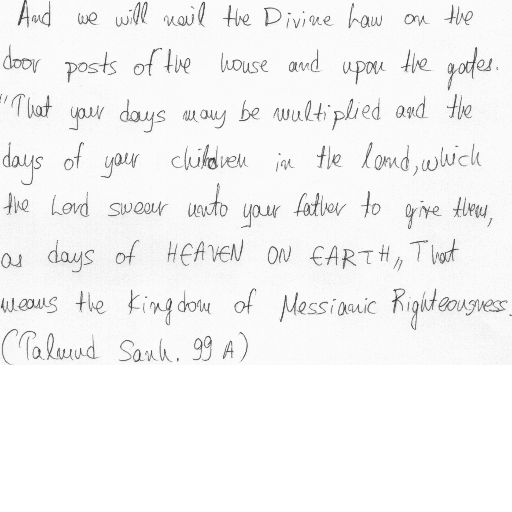

In [26]:
Image.fromarray(img)

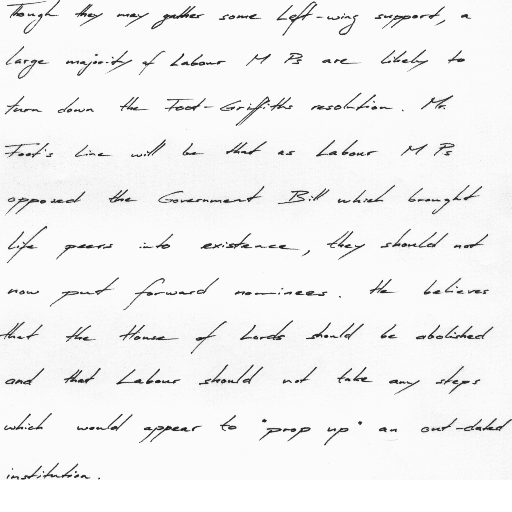

In [21]:
Image.fromarray(p["train"]['dt'][3])

In [10]:
for set_name in ["train", "test", "valid"]:
    for i,v in enumerate(p[set_name]['gt']):
        p[set_name]['gt'][i] = p[set_name]['gt'][i][:-4]

In [11]:
import glob

In [12]:
ddf = pd.read_csv("raw/synthetic_data/gt.csv")

In [13]:
ddf = ddf.set_index(['0'])

In [14]:
labels = ddf.to_dict()["1"]

In [15]:
labels['img0.png']

'energetic man with a gentle and charming character , \n exports to Germany will now be a little cheaper \n like Alice in Wonderland , " Doc gently mocked her , " and \n intelligent " than the wife ( as she \n FRANK FOULKES , Communist president \n utterly extraordinary , " said Serena angrily , \n Let us consider first what would \n isn\'t , " he ended sadly . " I tried to read the'

In [16]:
pil = Image.open("raw/synthetic_data/img30000.png") 

UnidentifiedImageError: cannot identify image file 'raw/synthetic_data/img30000.png'

In [21]:
def format_IAM_paragraph_2(paths):
    
    imgs = []
    gt = []
    for path in paths:
        try:
            with Image.open(path) as pil_img:
                img = np.array(pil_img)
        except:
            print("error in", path)
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = resize(img, size)
        imgs.append(img)
        key = path.split("/")[-1]
        gt.append(labels[key])
    return gt,imgs


In [12]:
img_paths = glob.glob("raw/synthetic_data/*.png")

In [17]:
n = len(img_paths)//16

In [18]:
chunks = [img_paths[i:i + n] for i in range(0, len(img_paths), n)]

In [22]:
result_chunks = Parallel(n_jobs=16)(
        delayed(format_IAM_paragraph_2)(chunk)
        for chunk in chunks)   

error in raw/synthetic_data/img33334.png
error in raw/synthetic_data/img30000.png
error in raw/synthetic_data/img3335.png
error in raw/synthetic_data/img39999.png
error in raw/synthetic_data/img46666.png
error in raw/synthetic_data/img3.png
error in raw/synthetic_data/img13336.png
error in raw/synthetic_data/img6670.png
error in raw/synthetic_data/img49995.png
error in raw/synthetic_data/img10002.png
error in raw/synthetic_data/img23334.png
error in raw/synthetic_data/img16669.png
error in raw/synthetic_data/img43332.png
error in raw/synthetic_data/img26667.png
error in raw/synthetic_data/img36667.png
error in raw/synthetic_data/img20001.png


In [23]:
imgs = []
gt = []
for i in result_chunks:
    gt.extend(i[0])
    imgs.extend(i[1])


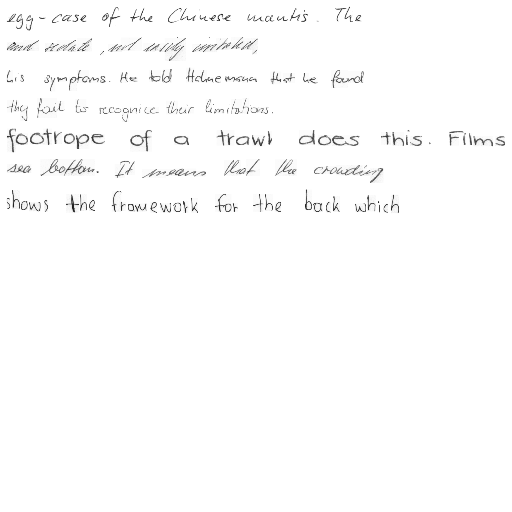

In [29]:
Image.fromarray(imgs[3001])

In [35]:
import pickle

In [37]:
for i in ["train", "test", "valid"]:
    with open("data/full_paragraph"+i+".zip","wb") as f:
        pickle.dump(p[i], f, protocol=pickle.HIGHEST_PROTOCOL)

In [100]:
with open('data/full_paragraphtest.zip', 'rb') as handle:
    unserialized_data = pickle.load(handle)

In [103]:
unserialized_data['dt'][0].shape

(605, 1820)

In [66]:
len(p['train']['dt'])

50731

In [6]:
import h5py

In [ ]:
for i in ["test"]:
    
    with h5py.File("data/iam_paragraph_512.hdf5", "a") as hf:
        hf.create_dataset(f"{i}/dt", data=p[i]['dt'], compression="gzip", compression_opts=9)
        hf.create_dataset(f"{i}/gt", data=p[i]['gt'], compression="gzip", compression_opts=9)
        print(f"[OK] {i} partition.")


In [9]:
source = "data/iam_paragraph_512.hdf5"
split = "test"

dataset = dict()

with h5py.File(source, "r") as f:
    dataset[split] = dict()

    dataset[split]['dt'] = np.array(f[split]['dt'])
    dataset[split]['gt'] = np.array(f[split]['gt'])


In [10]:
dataset[split]['dt'].shape

(336, 512, 512)

In [11]:
print(dataset[split]['gt'][0].decode())

Become a success with a disc and hey presto ! You 're a star ... . Rolly sings with \n assuredness " Bella Bella Marie " ( Parlophone ) , a lively song that changes tempo mid-way . \n I don't think he will storm the charts with this one , but it 's a good start . \n CHRIS CHARLES , 39 , who lives in Stockton-on-Tees , is an accountant .


# Synthentic data creation from here

In [1]:
import unicodedata
import pandas as pd

In [4]:
df = pd.read_csv('raw/iam/ascii/lines.txt', names=['filename','result','text'],escapechar='\\',
                 sep=" ", skiprows=23, header=None, usecols=[0,1,8],lineterminator="\n",quoting=3)

In [5]:
df["text"] = df.apply(lambda row: row.text.replace('|', ' '), axis=1)
len(df)

13353

In [7]:
def standardize_imgs(imgs, baseheight):
    resized_imgs = []
    for img in imgs:
        hpercent = (baseheight / float(img.size[1]))
        wsize = int((float(img.size[0]) * float(hpercent))) 
        img = img.resize((wsize, baseheight), Image.ANTIALIAS)
        resized_imgs.append(img)
    return resized_imgs

In [8]:
def create_img(imgs, num_lines, pad=30):
    w = 1
    h = num_lines
        
    widths, heights = zip(*(i.size for i in imgs))
    
    median_height = int(np.median(heights))
    stzd_imgs = standardize_imgs(imgs, median_height)
    lines = [stzd_imgs[i:i + w] for i in range(0, len(stzd_imgs), w)]
    
    total_width = max([np.sum([word.size[0] for word in line]) for line in lines]) + (pad*(w+1))   
    total_height = (median_height * h) + (pad*(h+1)) #sum(heights)

    new_im = Image.new('RGB', (total_width, total_height), color=(255,255,255))

    y_offset = pad
    x_offset = pad
    
    for line in lines:
        x_offset = pad
        for word in line:
            new_im.paste(word, (x_offset,y_offset))
            x_offset += word.size[0] + pad
        y_offset += median_height + pad
    
    return new_im

In [9]:
raw = "raw/synthetic_data/"

In [21]:
def create(l):
    lables = []
    for i in l:
        imgs = []
        lines = np.random.choice([4,5,6,7,8])
        temp = df.sample(lines, random_state=i)
        for name in temp['filename']:
            sname = name.split("-")
            path = sname[0]+'/'+"-".join(sname[:2])+'/'+name+".png"
            imgs.append(Image.open("raw/iam/lines/"+path))
        img = create_img(imgs, lines)
        lable = " \n ".join(temp['text'])
        img.save(raw+"img"+str(i)+".png")    
        lables.append(["img"+str(i)+".png", lable])
    return lables

In [10]:
l = list(range(50000))

In [12]:
n = len(l)//15

chunks = [l[i:i + n] for i in range(0, len(l), n)]

In [177]:
# def create_synthentic_data(number):
#     images = []
#     lables = []
#     for i in range(10000*(-1+number), 10000*number):
#         lines = np.random.choice([4,5,6,7,8])
#         temp = df.sample(lines, random_state=i)
#         imgs = []
#         for name in temp['filename']:
#             sname = name.split("-")
#             path = sname[0]+'/'+"-".join(sname[:2])+'/'+name+".png"
#             imgs.append(Image.open("raw/iam/lines/"+path))
#         img = create_img(imgs, lines)
#         lable = " \n ".join(temp['text'])
#         images.append(img)
#         lables.append(lable)
#     return images, lables

In [16]:
from joblib import Parallel, delayed, cpu_count

In [24]:
result_chunks = Parallel(n_jobs=15)(
    delayed(create)(chunk)
    for chunk in chunks)

KeyboardInterrupt: 

In [30]:
results = []
for i in result_chunks:
    results.extend(i)

In [32]:
df = pd.DataFrame(results)

In [33]:
df.to_csv("raw/synthetic_data/gt.csv",index=False)

In [49]:
df['len'] = df[1].apply(len)

In [68]:
import timm

In [70]:
m  = timm.create_model('resnest50d', pretrained=True)

In [71]:
m

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNestBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (con

In [ ]:
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)   
        x = self.backbone.act1(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
